# Simulation and estimation in a Markov model of breast cancer

In this project, we will work with the following Markov model:

The model follows women after they had their breast tumor removed. The
cancer may reappear close to the removed tumor. This is called local recurrence, and the woman enters state 2. The cancer may also reappear distant
from where it was operated. This is called distant metastatis. Both things
may also occour. Death can occur from any state. In this model, once the
death state has been entered, it can never be left again. This means the
simulation should be terminated once this state has been reached

## Task 1

Assume that one time step equals one month. Simulate 1000 women, all
starting in state 1, until death. Summarize the lifetime distribution of the
women, after surgery, for example using a histogram. In what proportion of
women does the cancer eventually reappear, locally?

In [175]:
import numpy as np

# Our markov chain simulation, with given n: number of women and P: probability matrix (transition matrix)
def absorbing_markov(n, P):
    lifetime = []
    for _ in range(n):
        state = []
        # Initial state
        current_state = 0 # state 1 --> index 0
        state.append(current_state) # first state which is always state 1
        while current_state != 4:  # Absorbing state (death state)
            # Making a jump based on p=P[current state], returning the state index (state nr. -1)
            next_state = np.random.choice([0, 1, 2, 3, 4], p=P[current_state])
            state.append(next_state) # Keeping records of which state the women is in
            current_state = next_state # Change of state to next state
            if current_state == 4:
                lifetime.append(state) # keeping records of each lifetime

    return lifetime

# Probability matrix P with probabilities:
P = np.array([
    [0.9915, 0.005, 0.0025, 0.0, 0.001],  # state 1 to all the other
    [0.0, 0.986, 0.005, 0.004, 0.005],   # state 2: local recurrence
    [0.0, 0.0, 0.992, 0.003, 0.005],   # state 3:  distant metastatis
    [0.0, 0.0, 0.0, 0.991, 0.009],   # state 4: both local recurrence and distant metastatis
    [0.0, 0.0, 0.0, 0.0, 1.0]    # state 5: death state, no return hence 1.0 probabilites in P_[4][4]
])

nr_women = 1_000
## Simulating ##
lifetime = absorbing_markov(nr_women, P)
    

Fraction of women where the cancer re-appears locally (state 2) is 0.595 or 595 women out of 1000.
Mean of months lived after surgery: 266.95 and in years: 22.25


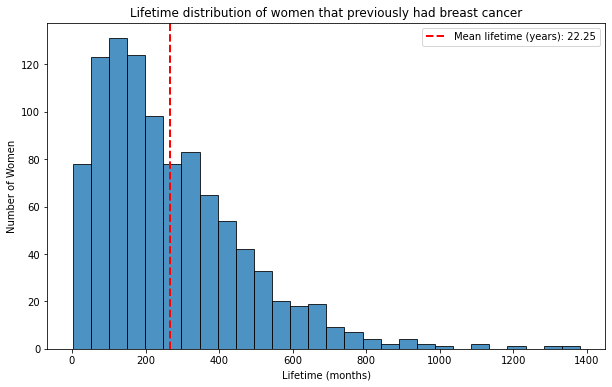

In [176]:
import matplotlib.pyplot as plt

# Manipulation and plotting a histogram
lifetimes_month = []
for i in range(len(lifetime)):
    lifetime_list = lifetime[i]
    lifetimes_month.append(len(lifetime_list))

lifetimes = np.array(lifetimes_month) # Calculating the lifetime of each women, in months

# Calculate the fraction of women where the cancer re-appears locally (state 2, index 1)
reappears = 0
for i in range(len(lifetime)):
    lifetime_list = lifetime[i]
    if 1 in lifetime_list:
        reappears += 1
frac_reappears = reappears/nr_women

print(
    f"Fraction of women where the cancer re-appears locally (state 2) is "
    f"{frac_reappears} or {reappears} women out of {nr_women}.")

mean_lifetime= np.mean(lifetimes)
print(f"Mean of months lived after surgery: {mean_lifetime:.2f} and in years: {mean_lifetime/12:.2f}")

# Plotting histogram
plt.figure(figsize=(10,6))
plt.hist(lifetimes,bins="auto", alpha=0.8, edgecolor="black")
plt.title('Lifetime distribution of women that previously had breast cancer')
plt.axvline(mean_lifetime, color='red', linestyle='dashed', linewidth=2, 
            label=f'Mean lifetime (years): {mean_lifetime/12:.2f}')
plt.xlabel('Lifetime (months)')
plt.ylabel('Number of Women')
plt.legend()
plt.show()

## Task 2


Simulations can be validated by ensuring they are consistent with analytical results. One way to do this, is to ensure the distribution over the states at a certain time is consistent with what we expect.

Let **$p_t$** denote the probability distribution over the states at time *t*. This
distribution can be found from the following formula:

$p_t = p_0(P^t)$.

In your simulations, what is the distribution over the states at $t = 120$? Does this correspond to what we expect? Answer the question using an
appropriate statistical test.

In [177]:
# absorbing markov chain with specific timesteps
def absorbing_markov_time_steps(n, P, t_time_steps):
    state_at_t = []
    for _ in range(n):
        current_state = 0 # state 1 --> index 0
        for i in range(t_time_steps):
            # Making a jump based on p=P[current state], returning the state index (state nr. -1)
            next_state = np.random.choice([0, 1, 2, 3, 4], p=P[current_state])
            current_state = next_state # Change of state to next state
        state_at_t.append(current_state)
    return np.array(state_at_t)

states = absorbing_markov_time_steps(nr_women, P, t_time_steps=120)

In [178]:
# Analytical solution, p_t = p_0(P^t) where t=120
t=120
p_0 = [1, 0, 0, 0, 0]
P_t = np.linalg.matrix_power(P, t)
p_t = np.round(p_0 @ P_t * nr_women)
p_t

array([359., 159., 166.,  68., 248.])

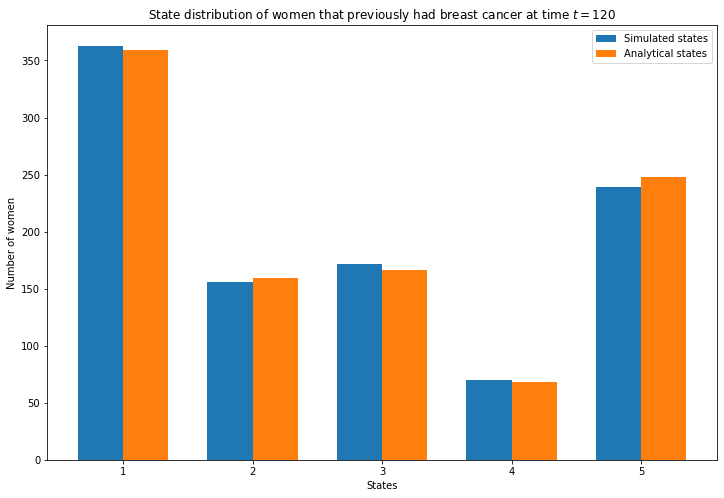

In [100]:
# Set the positions and width for the bars
ind = np.arange(5)  # the x locations for the groups
width = 0.35  # the width of the bars

# Plotting the bars
fig, ax = plt.subplots(figsize=(12, 8))
bar1 = ax.bar(ind - width/2, np.bincount(states), width, label='Simulated states')
bar2 = ax.bar(ind + width/2, p_t, width, label='Analytical states')

# Adding labels, title, and legend
ax.set_xlabel('States')
ax.set_ylabel('Number of women')
ax.set_title('State distribution of women that previously had breast cancer at time $t=120$')
ax.set_xticks(ind)
ax.set_xticklabels(['1', '2', '3', '4', '5'])  # Example categories
ax.legend()

# Display the plot
plt.show()

In [179]:
from scipy.stats import chi2_contingency

# Perform chi-squared test
chi2, p_value, dof, expected = chi2_contingency([np.bincount(states), p_t])

# Print results
print(f"Chi-squared statistic: {chi2}")
print(f"P-value: {p_value}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")

# Interpret the p-value
alpha = 0.05
if p_value < alpha:
    print("Reject null hypothesis: There is a significant difference between the distributions.")
else:
    print("Fail to reject null hypothesis: There is no significant difference between the distributions.")

Chi-squared statistic: 2.165550948158036
P-value: 0.7053408574277327
Degrees of freedom: 4
Expected frequencies:
Fail to reject null hypothesis: There is no significant difference between the distributions.


## Task 3
The above approach only validates the simulation at a certain time point. A
better approach is to ensure the emperical lifetime distribution matches the theoretical.
It can be shown that the lifetime, T, follows a so-called discrete phase-type
distribution. This distribution has probability mass function

$P(T=t) = \pi (P_s)^t p_s$

and mean

$E(T) = \pi (I - P_s)^{-1}1$

Where $\pi$ is the distribution over states 1, 2, 3, 4 at t = 0. $P_s$ is a 4 × 4
sub-matrix of P formed by removing the last row and column. $p_s$ is column
vector indicating the probability of dying from states 1, 2, 3, 4. 1 is a vector
of ones of appropriate dimension.

Does your simulated lifetimes follow this distribution?

In [170]:
# Calculating the analytical solution
pi = np.array([1, 0, 0, 0]) # initial distribution, always start at state 1
P_s = P[:-1, :-1] # Removing last row and last column from P
p_s = P[0:4, -1] # Probabilities of dying from state 1 to 5
I = np.eye(len(P_s)) # Identity matrix
ones = np.ones(len(P_s)) # ones matrix

def pmf(t, pi, P_s, p_s):
    pmf_t = pi @ np.linalg.matrix_power(P_s, t) @ p_s
    return pmf_t

# Calculating the analytical lifetime and mean
ts = np.arange(1000)
analytical_lifetime = [pmf(t, pi, P_s, p_s) for t in ts]
analytical_mean = pi @ np.linalg.inv(I - P_s) @ ones

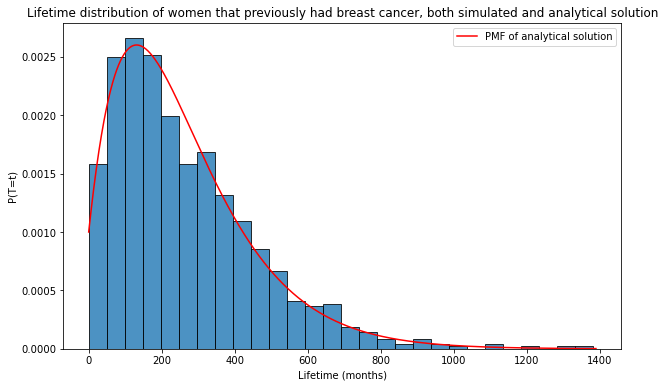

In [181]:
# Plotting histogram and pmf of analytical solution
plt.figure(figsize=(10,6))
plt.hist(lifetimes ,bins="auto", alpha=0.8, edgecolor="black", density=True)
plt.plot(analytical_lifetime, label='PMF of analytical solution', color='red')
plt.title('Lifetime distribution of women that previously had breast cancer, both simulated and analytical solution')            
plt.xlabel('Lifetime (months)')
plt.ylabel('P(T=t)')
plt.legend()
plt.show()